## Introduction

***Data leakage***은 training data가 target에 대한 정보를 포함할 때 발생하지만 모델의 예측을 할 때 유사한 데이터를 사용할 수 없다. 이로 인해 training set의 성능은 향상되지만 실제 모델은 저조한 성능을 발휘하게 된다.<br><br>
다시 말해, leakage는 decision을 시작할 때까지는 모델이 정확한 것 처럼 보이지만 그 이후에는 부정확해진다.<br><br>
두가지 leakage type이 있다 : ***target leakage*** 와 ***train_test contamination***

### Target leakage
***Target leakage***는 예측자가 예측할 때 사용할 수 없는 데이터를 포함할 때 발생한다. 단순히 어떤 feature가 좋은 예측을 하는데 도움이 되는지가 아니라, 데이터를 사용할 수 있게 되는 시기나 시간순으로 target leakage에 대해 생각하는 것이 중요하다. <br><br>
폐렴 예측을 한다고 생각해보자.
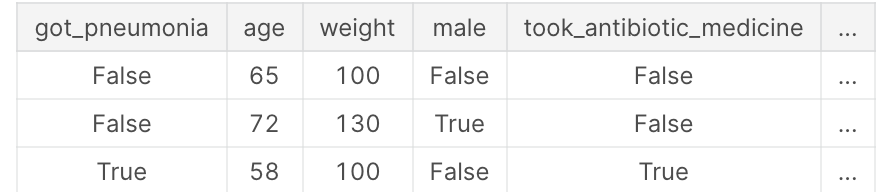

사람들은 폐렴에 걸린 후 회복을 위해 항생제를 복ㅇㅇ한다. raw data는 이러한 열 간의 강한 관계를 보여주지만 ```got_pneumonia```값이 결정되면 ```took_antibiotic_medicine```이 자주 변경된다. 이것이 target leakage다.<br><br>
모델은 ```took_antibiotic_medicine``` 값이 false면 폐렴이 없다는 것을 알 수 있다. 검증 데이터는 독일한 source에서 제공되기 때문에 검증에서 반복되고 모델은 큰 validation scores를 갖게된다.<br><br>
하지만 모델은 실제로는 매우 부정확하게 나타날 수 있다. 폐렴에 걸릴 환자들의 향후 건강에 대한 예측을 할 때 항생제를 아직 받지 못했을 것이기 때문이다.
<br><br>
이러한 유형의 data leakage를 방지하려면 대상 값이 실현된 후 업데이트 되거나 생성된 변수를 제외해야된다.
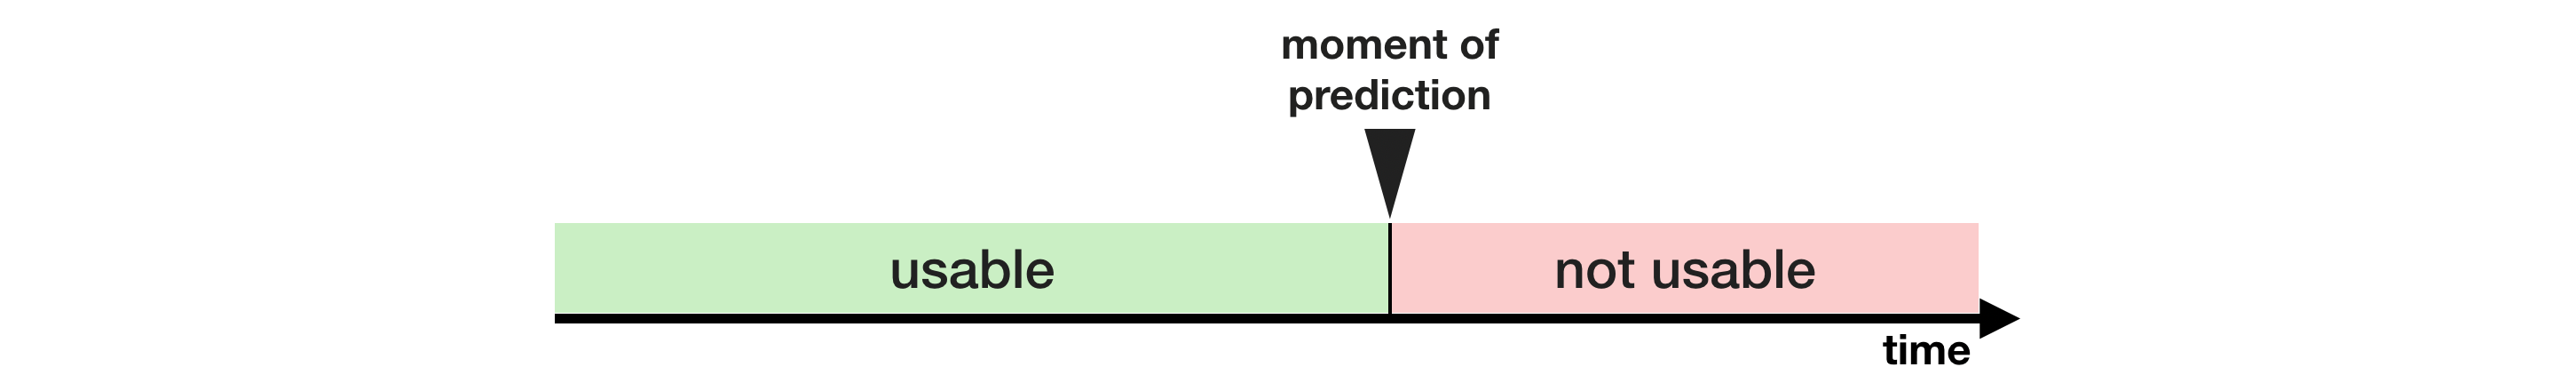

### Train_Test Contamination
다른 유형의 leak은 training data와 validation data 구별에 주의하지 않을 때 일어난다. <br><br>
검증은 모델이 이전에 고려하지 않은 데이터에 대해 수행하는 방법의 척도이다. 검증 데이터가 전처리 동작에 영향을 미치는 경우 프로세스를 미묘한 방법으로 손상시킬 수 있다. 이를 train-test contamintaion이라고 한다.

## Example

In [3]:
import pandas as pd

data = pd.read_csv('../input/aer-credit-card-data/AER_credit_card_data.csv', 
                   true_values = ['yes'], false_values = ['no'])

y = data.card

X = data.drop(['card'], axis=1)

print("Number of rows in the dataset:", X.shape[0])
X.head()

Number of rows in the dataset: 1319


,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,0,37.66667,4.5200,0.033270,124.983300,True,False,3,54,1,12
1,0,33.25000,2.4200,0.005217,9.854167,False,False,3,34,1,13
2,0,33.66667,4.5000,0.004156,15.000000,True,False,4,58,1,5
3,0,30.50000,2.5400,0.065214,137.869200,False,False,0,25,1,7
4,0,32.16667,9.7867,0.067051,546.503300,True,False,2,64,1,5


In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

my_pipeline = make_pipeline(RandomForestClassifier(n_estimators=100))

cv_scores = cross_val_score(my_pipeline, X, y,
                           cv=5,
                           scoring='accuracy')
print("Cross-validation accuracy: %f" % cv_scores.mean())

Cross-validation accuracy: 0.981052


data tab을 보면 몇가지 의심스러운 변수들이 있다.<br>
```expenditure```은 이 카드에 지출하는 것을 의미하는지 신청하기 전에 사용한 카드에 지출하는 것을 의미하는지.

In [8]:
expenditures_cardholders = X.expenditure[y]
expenditures_noncardholders = X.expenditure[~y]

print('Fraction of those who did not receive a card and had no expenditures: %.2f' \
      %((expenditures_noncardholders == 0).mean()))
print('Fraction of those who received a card and had no expenditures: %.2f' \
      %(( expenditures_cardholders == 0).mean()))

Fraction of those who did not receive a card and had no expenditures: 1.00
Fraction of those who received a card and had no expenditures: 0.02


위와 같이 카드를 받지 않은 사람은 모두 지출이 없고 카드를 받은 사람의 2% 만 지출을 하지 않았다.
우리 모델이 정확도가 높은 것은 그리 놀랍지 않지만 아마 그들이 신청한 카드에 대한 지출을 의미하는 target leakage의 사례인 것 같다.<br><br>
```share```가 부분적으로 ```expenditure```를 결정하기 때문에 배제되어야 하고 ```active```와 ```majorcards``` 값이 명백하지 않아 제외한다.
데이터를 만든 사람을 찾아 많은 정보를 얻을 수 없다면 안전한 것이 더 좋다.

In [14]:
potential_leaks = ['expenditure', 'share', 'active', 'majorcards']
X2 = X.drop(potential_leaks, axis=1)

cv_scores = cross_val_score(my_pipeline, X2, y,
                           cv=5,
                           scoring='accuracy')

print("Cross-val accuracy: %f" % cv_scores.mean())

Cross-val accuracy: 0.830171


정확도가 이전보다 낮지만 실제 적용을 할 때 target leakage 모델이 더 좋지 않을 수 있다.